In [40]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import pickle
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)

from pipeline import team_metadata, score_by_score, rank, playstats, merge

In [9]:
def plot(w=9, h=6):
    return plt.subplots(figsize=(w, h))

In [10]:
first_season = "2011-12"
last_season = "2021-22"
importlib.reload(merge)
m = merge.merge(first_season, last_season)


#### Empirical Means

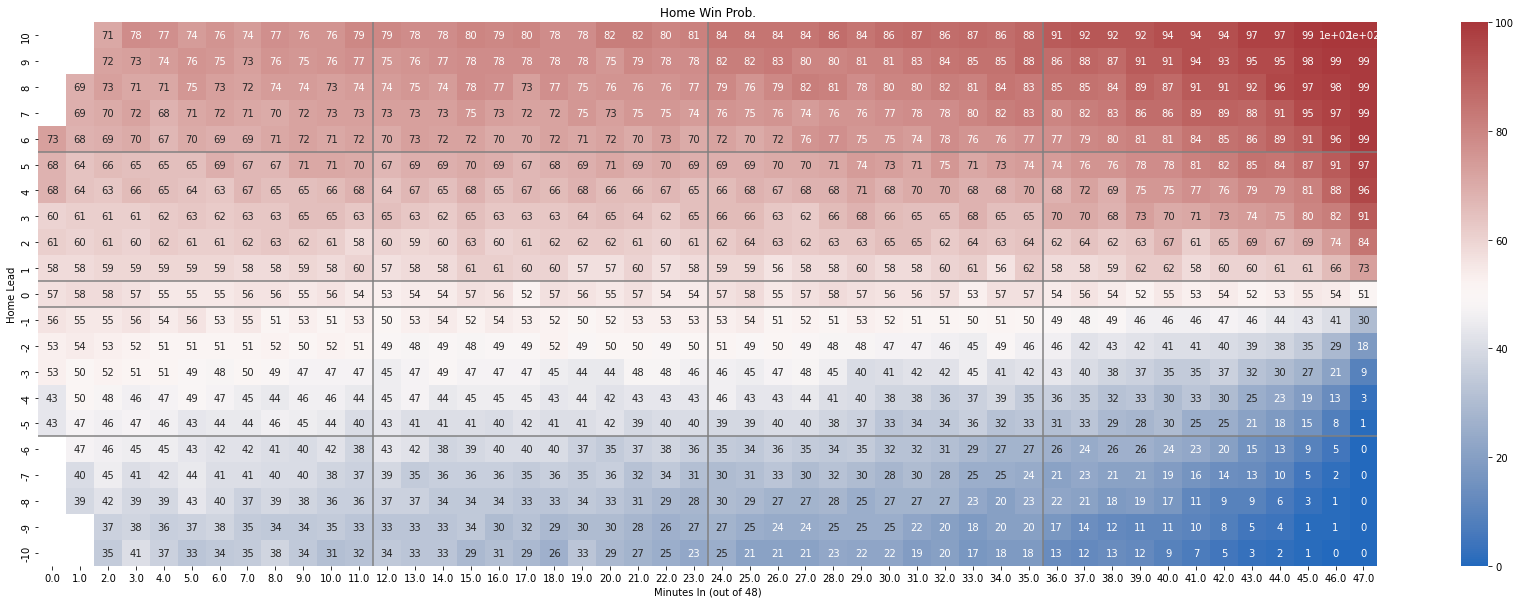

In [11]:
time_mod = 1
score_mod = 1

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 50]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(30, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



___

# FFNN

**TODO:** weight by season (more recent seasons heavier)

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from sklearn.preprocessing import StandardScaler


In [49]:
def score_model(m, features, layer_sizes, initializer_std=5, lr=1e-6, patience=3, batch_size=32, cutoff="2021-09-01"):
    
    ## Get data
    m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
    m_['time_left'] = np.log(48-m_['time'])
    m_['home_lead_pml'] = m_['home_lead'] / np.sqrt(48-m_['time'])
    X_train = m_.loc[m_['date'] <= cutoff, features].to_numpy()
    X_test = m_.loc[m_['date'] > cutoff, features].to_numpy()
    y_train = m_.loc[m_['date'] <= cutoff, 'home_win'].astype(int).to_numpy()
    y_test = m_.loc[m_['date'] > cutoff, 'home_win'].astype(int).to_numpy()
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
#     ## Model
#     # Construct
#     model = keras.Sequential()
#     model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
#     for layer_size in layer_sizes:
#         initializer = keras.initializers.RandomNormal(mean=0.0, stddev=initializer_std/100, seed=None)
#         model.add(layers.Dense(layer_size, activation="relu", kernel_initializer=initializer))    
#     model.add(layers.Dense(1, activation='sigmoid'))
#     print(model.summary())
#     # Compile
#     opt = keras.optimizers.Adam(learning_rate=lr)
#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
#     # Fit
#     callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
#     history = model.fit(
#         X_train_scaled,
#         y_train,
#         batch_size=batch_size,
#         epochs=500,
#         validation_data=(X_test_scaled, y_test),
#         callbacks=[callback],
#         verbose=2
#     )
#     # Score
#     score = history.history['val_loss'][-1]
    
#     ## Write out
#     name = "_".join([str(size) for size in layer_sizes]) + "|" + str(initializer_std) + "|" + str(patience) +  "|" + str(lr) + "|" + "_".join(features)
#     details = {'features': features, 'layer_sizes': layer_sizes, 'score': score}
    # with open(f"model/scores/{name}.json", 'w') as f:
        # json.dump(details, f)
    with open(f"model/scalers/{name}", 'wb') as f:
        pickle.dump(ss, f)
        
    ## Return model
    # return model, history, ss, name


In [50]:
# import pickle
# pickle.dump(sc, open('file/path/scaler.pkl','wb'))

# sc = pickle.load(open('file/path/scaler.pkl','rb'))

In [51]:
## Get features
features = ['home_lead', 'time_left', 'home_ranking', 'vis_ranking', 'home_lead_pml']
layer_sizes = [16, 32, 8]
initializer_std=2
patience=3
lr=2.5e-6
batch_size=64
cutoff="2021-09-01"
model, history, ss, name = score_model(m, features, layer_sizes, initializer_std, lr, patience, batch_size, cutoff)
# model = keras.models.load_model(hoops_dir / "model/models/16_32_8|2|3|2.5e-06|home_lead_time_left_ppm_home_ranking_vis_ranking_home_lead_pml/")



TypeError: cannot unpack non-iterable NoneType object

In [33]:
# name = "_".join([str(size) for size in layer_sizes]) + "|" + str(initializer_std) + "|" + str(patience) +  "|" + str(lr) + "|" + "_".join(features)
# details = {'features': features, 'layer_sizes': layer_sizes, 'score': history.history['val_loss'][-1]}
# with open(f"model/scores/{name}.json", 'w') as f:
#     json.dump(details, f)

In [34]:
# model.save(hoops_dir / f"model/models/{name}")

2022-03-11 23:12:06.210479: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/danielfriedman/Desktop/hoops/model/models/16_32_8|2|3|2.5e-06|home_lead_time_left_home_ranking_vis_ranking_home_lead_pml/assets


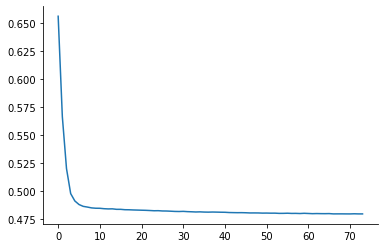

In [35]:
i=0
sns.lineplot(x=np.arange(len(history.history['val_loss'][-i:])), y=history.history['val_loss'][-i:])
sns.despine()

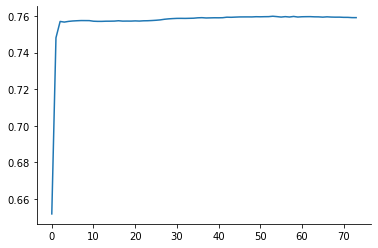

In [36]:
sns.lineplot(x=np.arange(len(history.history['val_acc'])), y=history.history['val_acc'])
sns.despine()

In [37]:
def get_win_probs_by_game_state(model, features, m, ss, home_ranking=0, vis_ranking=0, mins=np.arange(0, 48), home_leads=np.arange(-10, 11), mean_replacers=None):
    m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
    n_combos = len(mins)*len(home_leads)
    mean_replacers = mean_replacers if mean_replacers is not None else dict()
    dummy_features = [f for f in features if f in m.columns]
    dummy_row = pd.DataFrame(m[dummy_features].mean()).T
    for feature, value in mean_replacers.items():
        dummy_row.loc[0, feature] = value
    dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
    time = np.tile(mins, len(home_leads))
    dummy_data['time_left'] = np.log(48-time)
    dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
    dummy_data['home_lead_pml'] = dummy_data['home_lead']/np.sqrt(48-time)
    dummy_data['home_ranking'] = home_ranking
    dummy_data['vis_ranking'] = vis_ranking
    dummy_data_scaled = ss.transform(dummy_data[features].to_numpy())
    dummy_data['yhat'] = model.predict(dummy_data_scaled)[:,0]
    dummy_data['time'] = time
    panel = dummy_data.pivot(index='home_lead', columns='time', values='yhat')
    return panel


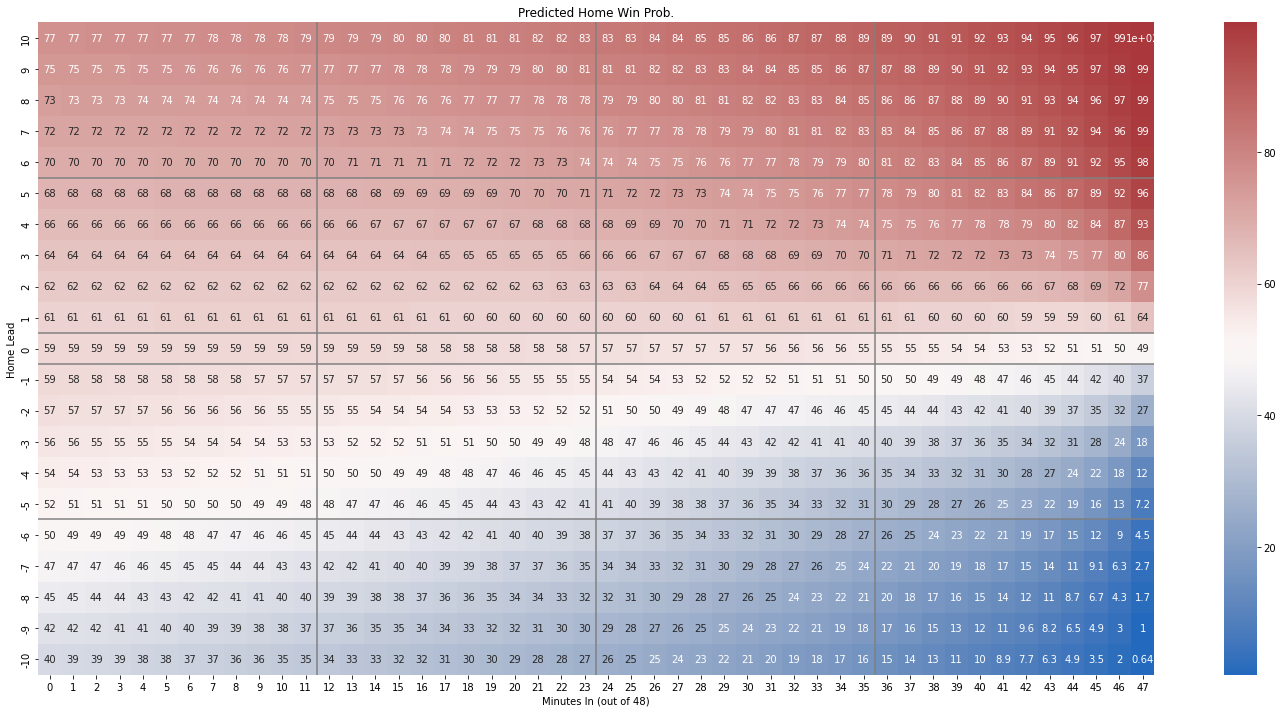

In [38]:
# Get win probs
panel_even = get_win_probs_by_game_state(model, features, m, ss)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_even[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_even[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


<AxesSubplot:xlabel='home_lead'>

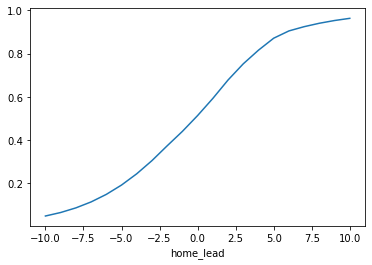

In [39]:
sns.lineplot(x=panel_even[44].index, y=panel_even[44].values)

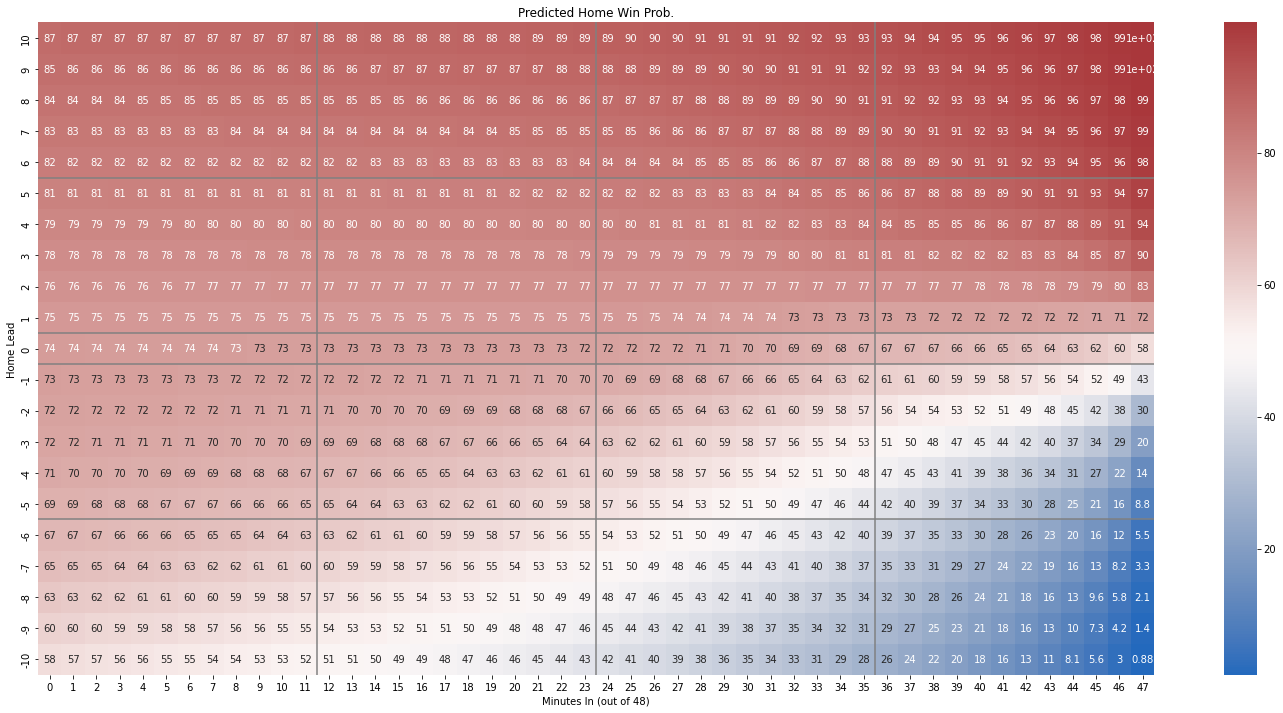

In [287]:
# Get win probs
panel_home_fav = get_win_probs_by_game_state(model, features, m, ss, home_ranking=.5, vis_ranking=-.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_home_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_home_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


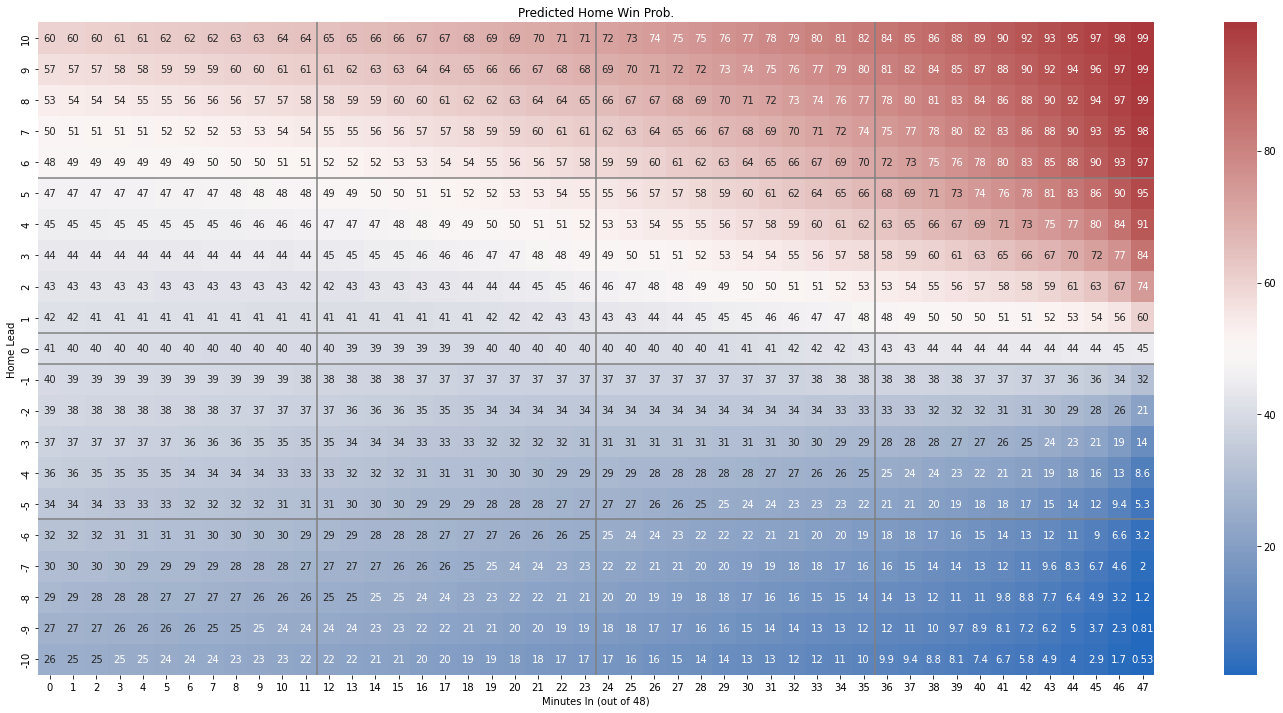

In [288]:
# Get win probs
panel_vis_fav = get_win_probs_by_game_state(model, features, m, ss, home_ranking=-.5, vis_ranking=.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_vis_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_vis_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


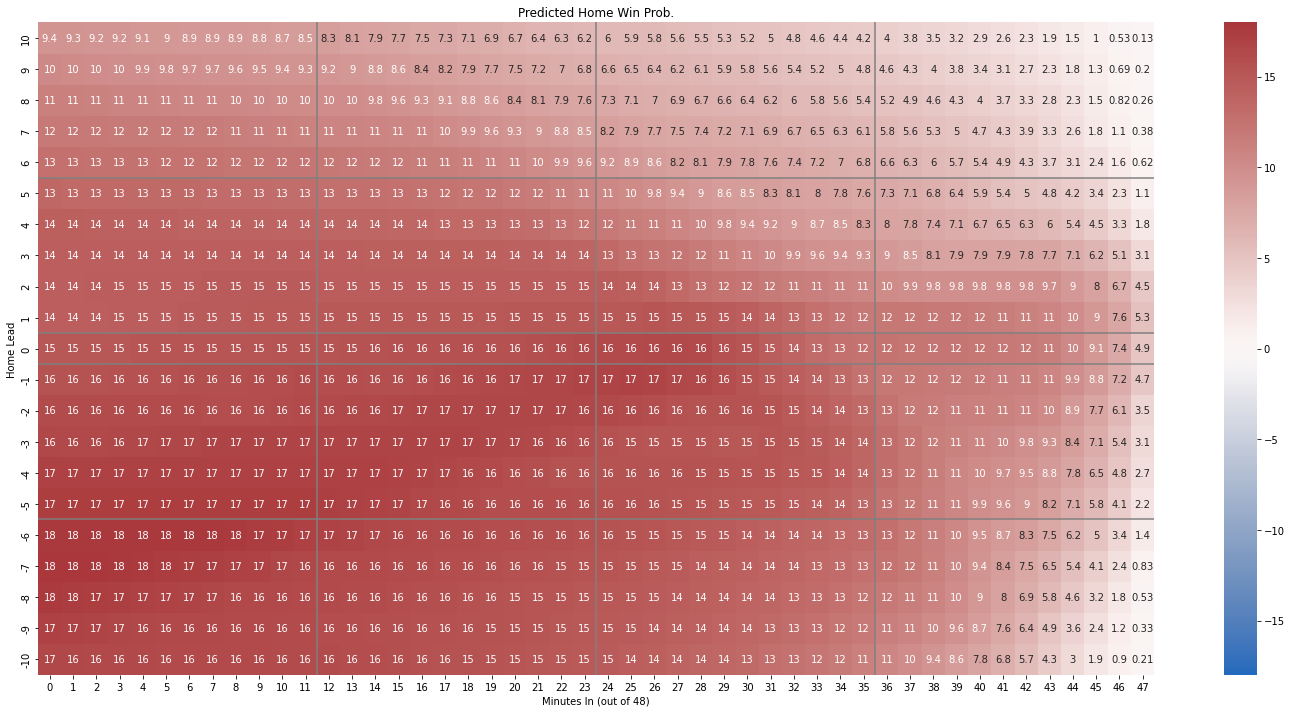

In [289]:
# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
panel_diff = (panel_home_fav[::-1] - panel_even[::-1])*100
vmax = max(-panel_diff.min().min(), panel_diff.max().max())
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_diff, annot=True, cmap="vlag", vmin=-vmax, vmax=vmax)
else:
    sns.heatmap(panel_diff, annot=False, cmap="vlag", vmin=-vmax, vmax=vmax)
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


____

In [290]:
sbs = pd.read_csv("data/score_by_score/2021-22.csv")
sbs.loc[sbs['date'] == "2022-03-03"].sample(5)

,game_id,date,home,vis,time,home_score,vis_score,home_win
95896,22100940,2022-03-03,BOS,MEM,30.32,70,58,True
89717,22100942,2022-03-03,TOR,DET,22.08,52,53,False
101521,22100944,2022-03-03,SAS,SAC,30.23,67,81,False
95839,22100940,2022-03-03,BOS,MEM,2.02,5,5,True
89799,22100943,2022-03-03,DAL,GSW,4.57,16,9,True


In [368]:
game_sbs = sbs.loc[sbs['game_id'] == 22100941]


In [291]:
rbd = pd.read_csv("data/rankings/2021-22.csv")

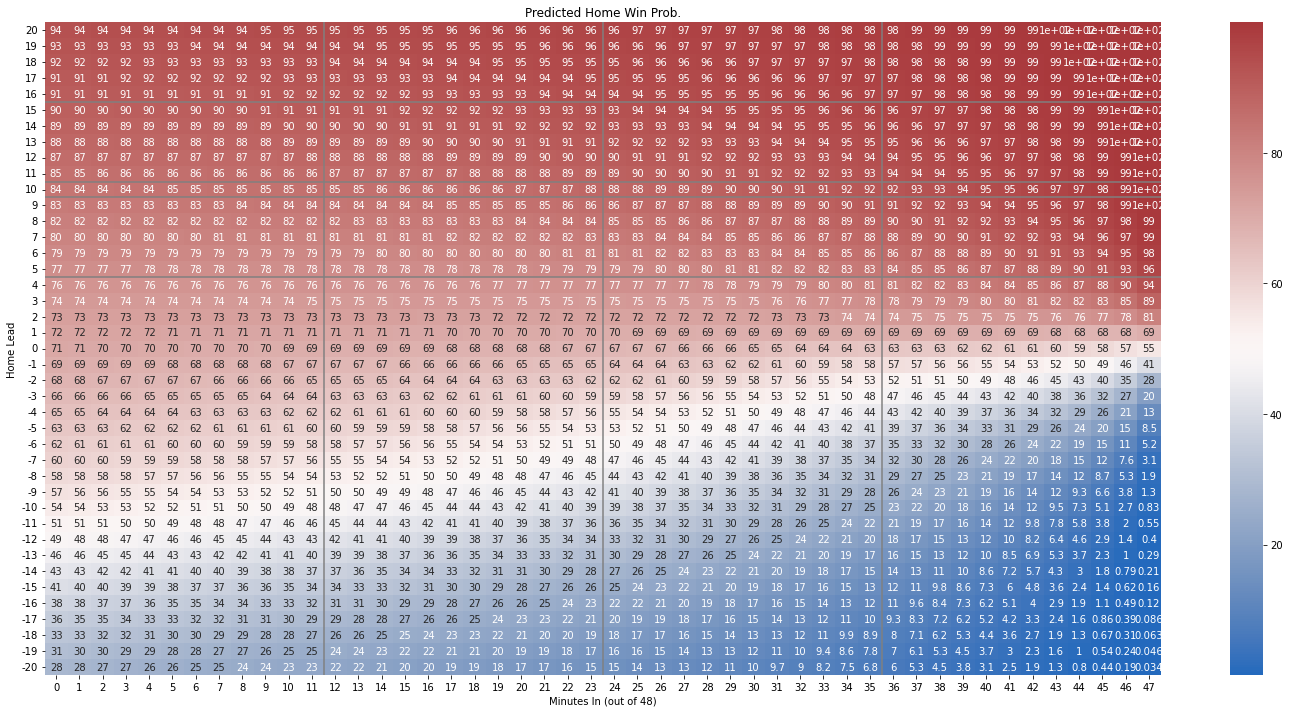

In [323]:
home = game_sbs.iloc[-1]['home']
vis = game_sbs.iloc[-1]['vis']
home_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[home]
vis_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[vis]
panel = get_win_probs_by_game_state(model, features, m, ss, home_ranking=home_ranking, vis_ranking=vis_ranking, home_leads=np.arange(-20, 21))

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


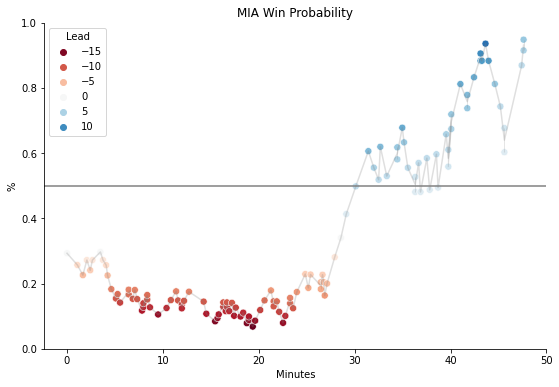

In [296]:
probs = list()
home_leads = list()
time = list()
for _, row in game_sbs.iterrows():
    probs.append(panel.loc[row['home_score']-row['vis_score'], np.floor(row['time'])])
    home_leads.append(row['home_score']-row['vis_score'])
    time.append(row['time'])

last_row = game_sbs.iloc[-1]
if last_row['home_score'] < last_row['vis_score']:
    probs = [1-prob for prob in probs]
    leads = [-home_lead for home_lead in home_leads]
    winner = last_row['vis']
else:
    leads = home_leads
    winner = last_row['home']

fig, ax = plt.subplots(figsize=(9, 6))
max_lead = max(-min(leads), max(leads))
sns.scatterplot(x=time, y=probs, hue=leads, palette="RdBu", hue_norm=(-max_lead, max_lead), s=50)
sns.lineplot(x=time, y=probs, color="gray", alpha=0.25) 
ax.axhline(0.5, color='gray')
ax.set_ylim(0, 1)
plt.legend(title=f"Lead")
ax.set(xlabel="Minutes", ylabel="%", title=f"{winner} Win Probability")
sns.despine()


____

# Live Model

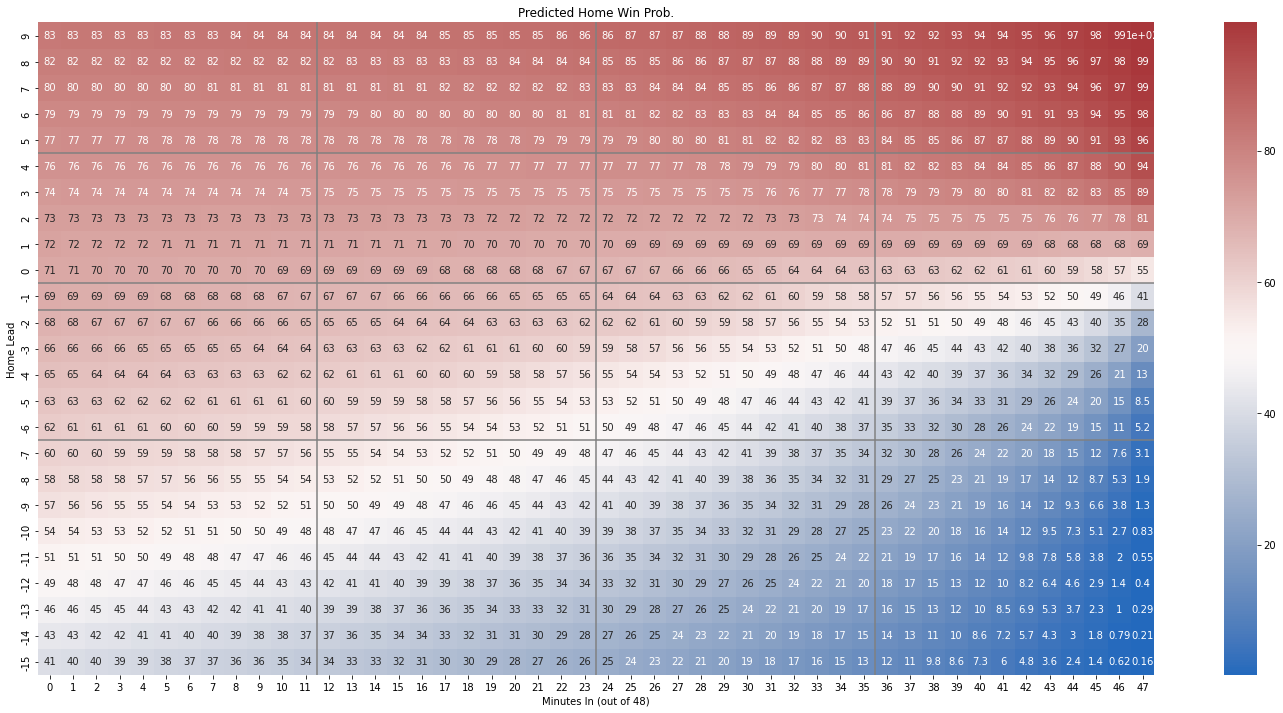

In [389]:
home = "GSW"
vis = "LAC"
home_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[home]
vis_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[vis]
panel = get_win_probs_by_game_state(model, features, m, ss, home_ranking=home_ranking, vis_ranking=vis_ranking, home_leads=np.arange(-15, 10))

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


In [379]:
def get_implied_prob(line):
    if line < 0:
        return -line/(-line + 100)
    else:
        return 100/(line + 100)

In [387]:
minute = np.floor(36-6.5)
home_lead = 66-45
home_line = -3200
vis_line = 1200
home_win_prob = panel.loc[home_lead, minute]
vis_win_prob = 1-home_win_prob
home_implied_win_prob = get_implied_prob(home_line)
vis_implied_win_prob = get_implied_prob(vis_line)
if home_win_prob > home_implied_win_prob:
    print("BET HOME")
if vis_win_prob > vis_implied_win_prob:    
    print("BET VIS")
print(round(home_win_prob, 3), round(home_implied_win_prob, 3))
print(round(vis_win_prob, 3), round(vis_implied_win_prob, 3))

BET HOME
0.976 0.97
0.024 0.077


In [388]:
minute

29.0